In [1]:
%matplotlib inline
import numpy as np
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Table
from astropy.io import fits
from astropy.modeling import models, fitting
from astropy.stats import sigma_clipped_stats
from astropy.stats import gaussian_sigma_to_fwhm
from photutils.datasets import make_random_gaussians
from photutils.datasets import make_noise_image
from photutils.datasets import make_gaussian_sources
from photutils import daofind
from photutils import psf
from photutils import CircularAperture
from photutils.psf import IntegratedGaussianPRF
from matplotlib import rcParams
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
rcParams['image.cmap'] = 'viridis'
rcParams['image.aspect'] = 1  # to get images with square pixels
rcParams['figure.figsize'] = (20,10)
rcParams['image.interpolation'] = 'none'
from daogroup import daogroup
from nstar import nstar

In [2]:
# generate artificial image
num_sources = 250
min_flux = 500
max_flux = 1000
min_xmean = 16
max_xmean = 240
sigma_psf = 2.0
ground_truth = make_random_gaussians(num_sources, [min_flux, max_flux],
                                     [min_xmean, max_xmean],
                                     [min_xmean, max_xmean],
                                     [sigma_psf, sigma_psf],
                                     [sigma_psf, sigma_psf],
                                     random_state=123)
shape = (256, 256)
image = (make_gaussian_sources(shape, ground_truth) +
         make_noise_image(shape, type='poisson', mean=1., random_state=123))
ground_truth.write('starlist_input.html')

In [3]:
# estimate background as the median after sigma clipping the sources
_, bkg, std = sigma_clipped_stats(image, sigma=3.0, iters=5)

# find potential sources with daofind
sources = daofind(image - bkg, threshold=4.0*std,
                  fwhm=sigma_psf*gaussian_sigma_to_fwhm)
intab = Table(names=['id', 'x_0', 'y_0', 'flux_0'],
              data=[sources['id'], sources['xcentroid'],
                    sources['ycentroid'], sources['flux']])
intab.write('starlist_initial_estimate.html')

In [4]:
# find groups using centroids initial estimates
groups = daogroup(intab, crit_separation=2.0*sigma_psf*gaussian_sigma_to_fwhm)

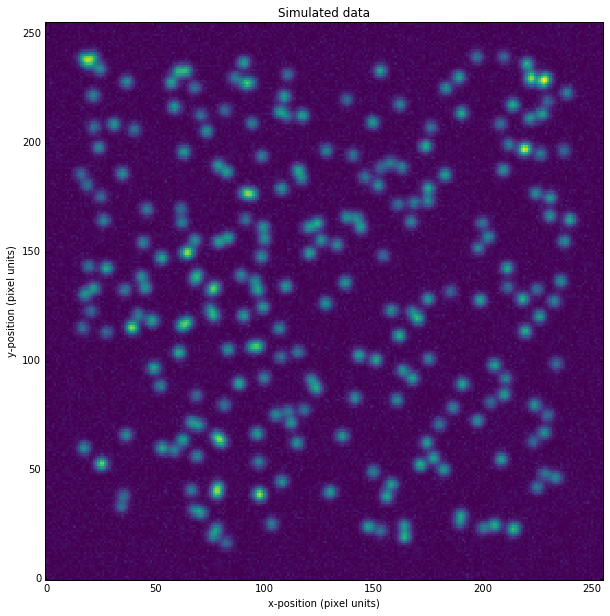

In [5]:
# plot synthetic data
plt.imshow(image, origin='lower', interpolation='nearest')
plt.title('Simulated data')
plt.xlabel('x-position (pixel units)')
plt.ylabel('y-position (pixel units)')

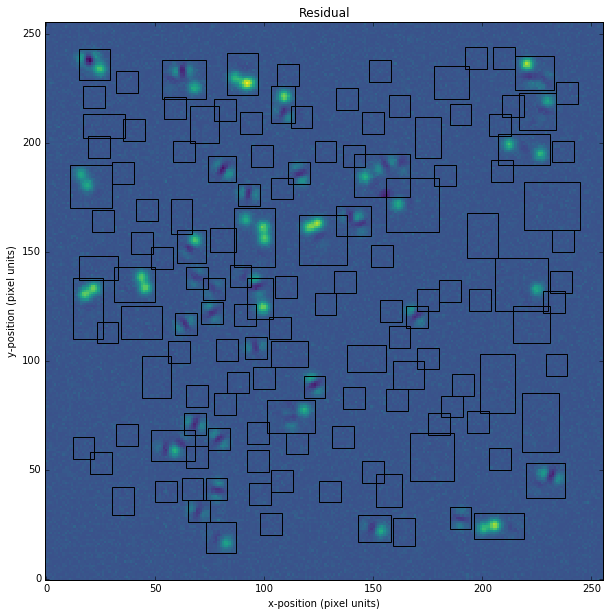

In [6]:
# fit 2D Gaussian PSF model to each group
tab, residual_image = nstar(image-bkg, groups, (5,5),
                            fitting.LevMarLSQFitter(),
                            IntegratedGaussianPRF, sigma=2.0)
tab.sort('id')
tab.write('starlist_estimated.html')
# plot residual image
plt.imshow(residual_image, origin='lower', interpolation='nearest')
# plot circular apertures around centroids initial estimates
for i in range(len(groups)):
    for j in range(len(groups[i]['id'])):
        # show ids
        # plt.text(groups[i]['x_0'][j], groups[i]['y_0'][j],
        #          str(groups[i]['id'][j]))
        aperture = CircularAperture((groups[i]['x_0'][j],
                                     groups[i]['y_0'][j]),
                                     r=sigma_psf*gaussian_sigma_to_fwhm)
        aperture.plot(lw=1.5, alpha=0.5)
plt.title('Residual')
plt.xlabel('x-position (pixel units)')
plt.ylabel('y-position (pixel units)')